In [2]:
from pandas import read_csv
import matplotlib.pyplot as plt

In [5]:
account = read_csv('../data/account.csv',delimiter=';')
card_dev = read_csv('../data/card_dev.csv',delimiter=';')
client = read_csv('../data/client.csv',delimiter=';')
disp = read_csv('../data/disp.csv',delimiter=';')
district = read_csv('../data/district.csv',delimiter=';')
loan_dev = read_csv('../data/loan_dev.csv',delimiter=';')
trans_dev = read_csv('../data/trans_dev.csv',delimiter=';')

/var/folders/04/05jdn06x4bd37twbh8c046nr0000gn/T/ipykernel_14429/3919381780.py:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  trans_dev = read_csv('../data/trans_dev.csv',delimiter=';')


<AxesSubplot:>

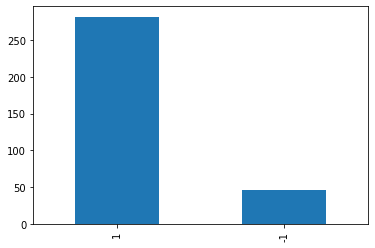

In [8]:
loan_dev['status'].value_counts().plot.bar()


In [ ]:
from datetime import datetime

def calculate_age(client):
  today = date.today()
  birth_date = datetime.strptime(client['birth number'], '%yy%mm%dd)
  
  female = birth_date.date.month >= 50
  
  client['age'] = today.year - birth_date .year - ((today.month, today.day) < (birth_date .month, birthdate.day))

  if female:
    client['sex'] = 'female' # or 1 ?
  else:
    client['sex'] = 'male' # or 0 ?
    
  return client

client = client.apply(lambda c: calculate_age(c))